Download this jupyter notebook in runnable format
[here](/uploads/2020/10/medianwage.ipynb) and view the post on my website [here](https://n8henrie.com/2020/10/us-median-income-over-time).

NB: There may be (hopefully minor) edits that are out of sync between the blog
post and the downloaded notebook.

In [1]:
# pip install git+https://github.com/n8henrie/nb_black
# This library automatically runs the `black` code formatter in jupyter cells.
# The n8henrie/nb_black fork is slightly modified to allow specifying a custom
# line length instead of using the default.
import lab_black

lab_black.load_ipython_extension(get_ipython(), line_length=79)

# US Median Wage Estimates, 1990-2019

I often hear that the average US citizen has an income of around $50,000 per
year. I hadn't previously seen where this number comes from, but recently I
found that the Social Security Administration provides some pretty interesting
data at their website.

For example, [here](https://www.ssa.gov/OACT/COLA/awi.gif) is the US average
wage index over time (displaying a local copy below):

![](/uploads/2020/10/awi.gif)

I recently discovered that they provide a webapp showing a summary of the US
W-2 reported income. Most interestingly, it includes binned data so one can
look at the changes in specific income brackets over time, and additionally
they provide an estimate of the *median* income as well.

An example URL for the webapp: <https://www.ssa.gov/cgi-bin/netcomp.cgi?year=2003>

## Median vs mean

Something I hadn't considered (for whatever reason) is that discussion on the
state of economic affairs based solely on the *average* income likely
misrepresents how *most* of the US is doing. The *median* income is probably
more representative of what most of us have in mind.

As an example, if we have a population of 100 individuals whose income is
normally distributed from 0 to 10 (choose whatever units you like), the mean
and median tend to be similar:

First 10 values of population: [5.37663355 3.77759921 2.8321777  4.88866131 4.02549337 7.890585
 8.07219506 4.30035334 2.18794887 2.15074077]

np.median(population)=4.921754367304535
np.mean(population)=4.982034011567311



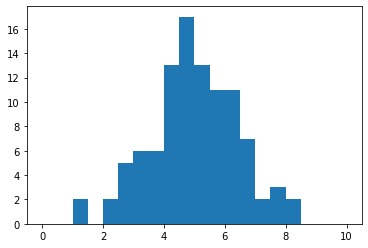

In [2]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng()
population = rng.normal(loc=5, scale=1.5, size=100)
print(
    f"""First 10 values of population: {population[:10]}

{np.median(population)=}
{np.mean(population)=}
"""
)
plt.hist(population, bins=20, range=[0, 10])

However, if we take *just one* member of the population and make their income
an extreme outlier, the *average* is improved, but the *median* is not
(assuming the outlier was selected from above the median to start with).

In [3]:
population.sort()
initial_median = np.median(population)
initial_mean = np.mean(population)

In [4]:
# Make the 49th richest (51st poorest) individual 100 times richer
population[51] *= 100

In [5]:
print(
    f"""Average income before: {initial_mean}
Average income after: {np.mean(population)}

Median income before: {initial_median}
Median income after: {np.median(population)}"""
)

Average income before: 4.982034011567312
Average income after: 9.940573583180026

Median income before: 4.921754367304535
Median income after: 4.921754367304535


We see that the *average* income of the population has nearly doubled!

While that *sounds* great, the truth of the matter is that *most* of this
population has not actually improved at all.

As a matter of fact, we could even have a situation where all but one lucky
individual see a *decrease* in their income, but the average *still* goes up.

In [6]:
population[:51] *= 0.95
population[52:] *= 0.95

In [7]:
print(
    f"""Average income before: {initial_mean}
Average income after: {np.mean(population)}

Median income before: {initial_median}
Median income after: {np.median(population)}"""
)

Average income before: 4.982034011567312
Average income after: 9.693976195516614

Median income before: 4.921754367304535
Median income after: 4.675666648939308


In this example, *99%* of the population is 5% *poorer* than they were to start with,
which is reflected by the dropping *median* income, but contrasts starkly with
a near **doubling** of the *average* income of the population.

Hopefully this is old news to most readers, but I think it was worth briefly
reviewing. Statistics matter! Especially when some people in our contry are
worth *hundreds of billions of dollars*, while the [official poverty rate][census]
is more than 10% -- some 33 million people.

[census]: https://www.census.gov/content/dam/Census/library/publications/2020/demo/p60-270.pdf "Income and Poverty in the United States: 2019"

## SSA data vs census data

Before going on to the SSA data, I wanted to point out that the SSA data below
differs *substantially* from the data available from the US Census (and for
fellow nerds, my understanding is that census.gov has a good API -- I look
forward to exploring their data soon!). For example, [their report][census]
shows the 2019 median household income to be about $68,000 -- *much* higher
than the SSA numbers below.

It seems like some of the important differences to keep in mind include:

- census includes *reported* data, the SSA is *measured* (W-2)
- census is *household* data, SSA is *individual*
    - one might expect 2-income households to be roughly twice as much on the census data as compared to SSA
- AFAIK, SSA is *only W-2 income*, meaning that capital gains and income from
  other work will not be reflectedin SSA, but may be included in what is
  reported by individuls in the census data

With that out of the way, on to the numbers!

[census]: https://www.census.gov/content/dam/Census/library/publications/2020/demo/p60-270.pdf "Income and Poverty in the United States: 2019"

In [8]:
# main dependencies for the notebook
import pickle
import re
import typing as t
from urllib.request import urlopen

import altair as alt
import pandas as pd
from sklearn.linear_model import LinearRegression

# NB: you will also need `pyarrow` installed to store and read dataframes from
# feather format. You don't need to import it, but uncomment below to test if
# you have it available.
# import pyarrow

In [9]:
# imports and helper function to run doctests
import copy
import doctest


def testme(func):
    """
    Automatically runs doctests for a decorated function.
    https://stackoverflow.com/a/49659927/1588795
    """
    globs = copy.copy(globals())
    globs.update({func.__name__: func})
    doctest.run_docstring_examples(
        func, globs, verbose=False, name=func.__name__
    )
    return func

In [10]:
# Build up some regular expressions to parse out the data from the
# relevant paragraphs
MONEY = r"\$[0-9,]+\.[0-9]{2}"
YEAR = r"\d{4}"
mean_re = re.compile(
    (
        'The "raw" average wage, computed as net compensation divided by the '
        f"number of wage earners, is {MONEY} divided by [0-9,]+, or "
        rf"({MONEY})\."
    ).strip()
)

median_re = re.compile(
    (
        "By definition, 50 percent of wage earners had net compensation less "
        "than or equal to the <i>median</i> wage, which is estimated to be "
        rf"({MONEY}) for {YEAR}\."
    ).strip()
)

In [11]:
@testme
def clean_number(string) -> float:
    """
    Turn a string of a dollar amount into a float.
    >>> clean_number("$123,456.78")
    123456.78
    """
    return float(string.lstrip("$").replace(",", ""))


def get_year(year: int) -> t.Dict[str, int]:
    """
    Get the median and mean for `year` from SSA.gov.
    """
    with urlopen(
        f"https://www.ssa.gov/cgi-bin/netcomp.cgi?year={year}"
    ) as req:
        resp = req.read().decode()
    clean_whitespace = " ".join(resp.split())

    median = median_re.search(clean_whitespace).group(1)
    mean = mean_re.search(clean_whitespace).group(1)
    return {
        "year": year,
        "median": clean_number(median),
        "mean": clean_number(mean),
    }

In [12]:
# If a feather file is available, load the dataframe from the local file.
# Otherwise, query ssa.gov for 1990-2019, create a dataframe, and make a
# local copy in feather format to prevent unnecessary http requests.
try:
    df = pd.read_feather("20201022_ssa_median_income.feather").set_index(
        "year"
    )
except FileNotFoundError:
    df = (
        pd.DataFrame(get_year(year) for year in range(1990, 2020))
        .set_index("year")
        .sort_index()
    )
    df.reset_index().to_feather("20201022_ssa_median_income.feather")

In [26]:
alt.Chart(df.reset_index().melt("year")).mark_line().encode(
    x="year:O",
    y=alt.Y("value", axis=alt.Axis(format="$,d", title="income $USD")),
    color=alt.Color("variable", legend=alt.Legend(title=None)),
).properties(title="Source: SSA.gov").interactive()

alt.Chart(...)

In [14]:
# Make a mapping of {year: dataframe} where the dataframe includes the entire
# chart of income levels. Again, once fetched, pickle the object locally to
# avoid unnecessary http requests. Please be familiar with security concerns
# when loading *untrusted* pickled data before running this block.

try:
    with open("income_dfs.pkl", "rb") as f:
        income_dfs = pickle.load(f)
except FileNotFoundError:
    income_dfs = {}
    for year in range(1990, 2020):
        tmp_df = pd.read_html(
            f"https://www.ssa.gov/cgi-bin/netcomp.cgi?year={year}"
        )[-2]
        tmp_df.columns = tmp_df.columns.droplevel()
        tmp_df[["Aggregate amount", "Average amount"]] = tmp_df[
            ["Aggregate amount", "Average amount"]
        ].apply(lambda x: x.str.lstrip("$").str.replace(",", "").astype(float))
        income_dfs[year] = tmp_df
    with open("income_dfs.pkl", "wb") as f:
        pickle.dump(income_dfs, f)

In [15]:
# Give an idea of the shape of this data
income_dfs[2003].head()

,Net compensation interval,Number,Cumulativenumber,Percentof total,Aggregate amount,Average amount
0,"$0.01 — 4,999.99",26312244,26312244,17.81198,5.361136e+10,2037.51
1,"5,000.00 — 9,999.99",15231616,41543860,28.12296,1.125687e+11,7390.46
2,"10,000.00 — 14,999.99",13262655,54806515,37.10107,1.651411e+11,12451.59
3,"15,000.00 — 19,999.99",12733058,67539573,45.72066,2.225614e+11,17479.02
4,"20,000.00 — 24,999.99",12034969,79574542,53.86769,2.703204e+11,22461.24


In [16]:
# Show that the bins from 1997 - 2019 are the same, but differ than 1996 and
# earlier

(
    (
        income_dfs[1996]["Net compensation interval"].eq(
            income_dfs[1997]["Net compensation interval"]
        )
    ).all(),
    (
        income_dfs[1997]["Net compensation interval"].eq(
            income_dfs[2019]["Net compensation interval"]
        )
    ).all(),
)

(False, True)

In [17]:
# Filter out the $50,000,000 and greater column
more_than_50_mil = (
    pd.DataFrame(
        pd.concat(
            [income_dfs[y].iloc[-1, [0, 1]], pd.Series(y, index=["year"])]
        )
        for y in income_dfs.keys()
        if y > 1996
    )
    .set_index("year")
    .sort_index()
)

In [25]:
chart = (
    alt.Chart(more_than_50_mil.reset_index())
    .mark_point()
    .encode(
        x="year:O",
        y="Number:Q",
    )
    .properties(title="# of income > $50,000,000 over time")
)

coef = (
    chart.transform_regression("year", "Number", params=True)
    .mark_text()
    .encode(
        x=alt.value(120),
        y=alt.value(50),
        text="coef:N",
    )
)

rSquared = (
    chart.transform_regression("year", "Number", params=True)
    .mark_text()
    .encode(
        x=alt.value(120),
        y=alt.value(75),
        text="rSquared:N",
    )
)
line = chart.transform_regression("year", "Number").mark_line()
(chart + coef + rSquared + line).interactive()

alt.LayerChart(...)

The chart above shows the parameters for the regression, but they're a little hard
to read. The most pertinent seems like it would be the slope -- the number of
people per year that are moving into the >= $50,000,000 per year range. Lets
build a little convenience function to make the slope easily accessible.

In [19]:
def get_slope(df: pd.DataFrame, column_name: str) -> float:
    """
    Returns the slope from a dataframe based on index and values from
    `column_name`
    >>> slope = pd.DataFrame({"A": [3, 5, 7]}).pipe(get_slope, "A")
    >>> np.isclose(slope, 2)
    True
    """
    lr = LinearRegression()
    lr.fit(
        df.index.values.reshape(-1, 1),
        df[column_name],
    )
    return lr.coef_[0]

In [20]:
slope = more_than_50_mil.pipe(get_slope, "Number")
mean = more_than_50_mil["Number"].mean()
print(
    f"""{slope=:.2f}
Average number of people in this group: {mean:.2f}
Group is increasing by about: {slope / mean:.2%} per year"""
)

slope=7.59
Average number of people in this group: 112.65
Group is increasing by about: 6.74% per year


Now lets look at the poorest of the poor.

In [21]:
less_than_5k = (
    pd.DataFrame(
        pd.concat(
            [income_dfs[y].iloc[0, [0, 1]], pd.Series(y, index=["year"])]
        )
        for y in income_dfs.keys()
        if y > 1996
    )
    .set_index("year")
    .sort_index()
)

In [27]:
chart = (
    alt.Chart(less_than_5k.reset_index())
    .mark_point()
    .encode(
        x="year:O",
        y="Number:Q",
    )
    .properties(title="Less than $5k")
)

coef = (
    chart.transform_regression("year", "Number", params=True)
    .mark_text()
    .encode(
        x=alt.value(120),
        y=alt.value(150),
        text="coef:N",
    )
)

rSquared = (
    chart.transform_regression("year", "Number", params=True)
    .mark_text()
    .encode(
        x=alt.value(120),
        y=alt.value(175),
        text="rSquared:N",
    )
)
line = chart.transform_regression("year", "Number").mark_line()
(chart + coef + rSquared + line).interactive()

alt.LayerChart(...)

In [23]:
slope = less_than_5k.pipe(get_slope, "Number")
mean = less_than_5k["Number"].mean()
print(
    f"""{slope=:.2f}
Average number of people in this group: {mean:.2f}
Group is decreasing by about: {-slope / mean:.2%} per year"""
)

slope=-357146.05
Average number of people in this group: 24614597.09
Group is decreasing by about: 1.45% per year


In [24]:
income_dfs[2019].iloc[-1]["Average amount"] / income_dfs[2019].iloc[0][
    "Average amount"
]

42460.35824745949

## Summary

The SSA provides some interesting an accessible data on income in the US. The
median income reported by the SSA is *way* lower than I thought it was, and
much lower than the household-level data reported by the census.

The number of Americans making more than $50 million per year is low, and is
increasing by about 6% per year (small denominator, this is less than 8
people). Each of them make as much per year as about 42,000 people in the
lowest bracket combined. The count of people in the lowest bracket is
decreasing by less than 2% per year. Hpefully this represents improvement in
their standard of living, though I suppose it could also be people dropping out
of the workforce completely.